# Primer on panel data fixed effects estimation

Under construction...

References:
 - [Cunningham (2021) chapter 8](https://mixtape.scunning.com/panel-data.html)

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import rpy2
import warnings
warnings.filterwarnings('ignore')
np.random.seed(5000)
%load_ext rpy2.ipython

In [2]:
%%R
library(dagitty)
library(plm)

Assume a population of $N$ individuals recorded over time periods $t=0, \dots , T$.

In [3]:
N=300
periods = list(np.arange(0, 12*30))
T = len(periods)

## Setting 1

The true data generating process for outcome variable of each individual $i$ is a unobserved effects model 

$$Y_{it} = u_i + \delta D_t + \epsilon_{i,t} \quad \quad i=1, \dots, N; \ t=1, \dots, T,$$

where $u_i \sim N(\mu_u, \sigma_u)$ are the un-observed individual effecta, $\delta$ is the treatment effect, and $\epsilon_{i,t} \sim N(\mu_{\epsilon}, \sigma_{\epsilon})$ are the idisuncratic noise terms. For each individual treatment status $D$ is applied according to following rules: everybody starts with $D_{i,0} = 0$. At each period $t$, individual with $D_{i,t} = 0$ has a probability $p_t$ to get assigned $D_{i,t+1} = 1$. At each period $t$, individual with $D_{i,t} = 1$ has a probability $p_c$ to get assigned $D_{i,t+1} = 0$. 

In [4]:
# DGP parameters
p_t = 0.01
p_c = 0.003
delta = 0.3
mu_u = 1
sigma_u = 3
mu_e = 0
sigma_e = 1

### Generate data

u shape: (360, 300)
eps shape: (360, 300)
D shape: (360, 300)


,time,individ,Y,u,D,epa
0,0,0,-1.889545,-0.93115,0.0,-0.958394


,Y,D
0,-1.889545,0.0


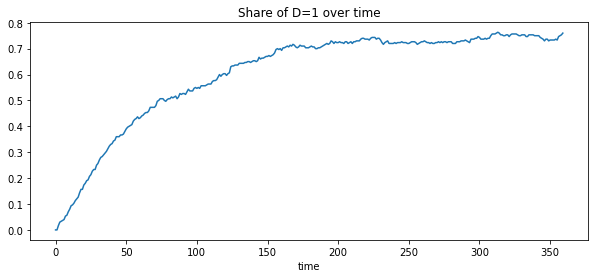

In [5]:
# u and eps
u = pd.DataFrame(np.tile(np.random.normal(mu_u, sigma_u, [1, N]), (T, 1)))
u.index.names = ["time"]
u.columns.names = ["individ"]

eps = pd.DataFrame(np.random.normal(mu_e, sigma_e, [T, N]))
eps.index.names = ["time"]
eps.columns.names = ["individ"]

# D; t first frame "other way around"
D = np.empty([N, T]) # At first frame "other way around"
D[:, :] = np.nan
D[:, 0] = 0
D = pd.DataFrame(D)
D.columns.names = ["time"]
D.index.names = ["individ"]

for t in range(0, T-1):
    
    D_0 = pd.DataFrame(D.loc[D[t]==0, t].copy())
    D_0.columns =["zeros"]
    D_1 = pd.DataFrame(D.loc[D[t]==1, t].copy())
    D_1.columns =["ones"]

    # Draw transfer probabilities and statuses for current zeros and ones
    D_0["tp"] = np.random.uniform(0, 1, len(D_0))
    D_0["ts"] = np.where(D_0["tp"] < p_t, 1, 0)
    D_1["tp"] = np.random.uniform(0, 1, len(D_1))
    D_1["ts"] = np.where(D_1["tp"] < p_c, 0, 1)
    
    # Append statuses to D
    D.loc[D_0.index.values, t+1] = D_0["ts"]
    D.loc[D_1.index.values, t+1] = D_1["ts"]   
D = D.T

# Y
Y = u + delta*D + eps

# Chceks
print("u shape: {}".format(u.shape))
print("eps shape: {}".format(eps.shape))
print("D shape: {}".format(D.shape))

# Plot treated share over time
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
(D.sum(axis=1) / N).plot(ax=ax)
_ = ax.set_title("Share of D=1 over time")

# Melt frames and combine into regression frame
combined = {"Y":Y.copy(), "u":u.copy(), "D":D.copy(), "epa":eps.copy()}
for key in combined:
    combined[key] = pd.melt(combined[key].reset_index(), id_vars='time')
    combined[key] = combined[key].rename(columns={"value":key})

for counter, key in enumerate(combined):
    if counter==0:
        df = combined[key].copy()
    else:
        df = pd.merge(df, combined[key].copy(), how="left", on=["time", "individ"])
df_reg = df[["Y", "D"]].copy()
display(df.head(1))
display(df_reg.head(1))

### Estimate treatment effec using fixed effects one-way within estimator

Even the tratement is assigned at individual level, one might need to estimate covariance matrix with individual-level clusters due to multiple time periods. See [here](https://blogs.worldbank.org/impactevaluations/when-should-you-cluster-standard-errors-new-wisdom-econometrics-oracle) under *The Experimental Design Reason for Clustering*.

In [6]:
%%R -i df -o out
formula = as.formula("Y ~ D")
model_fe = plm(
    formula=formula,
    data=df,
    effect="individual",
    index=c("individ"),
    model="within"
)
#out = summary(model_fe, vcov=NULL)
out = summary(model_fe, vcov=function(x) vcovHC(x, method="arellano", cluster="group"))

In [7]:
print(out)

Oneway (individual) effect Within Model

Note: Coefficient variance-covariance matrix supplied: function(x) vcovHC(x, method = "arellano", cluster = "group")

Call:
plm(formula = formula, data = df, effect = "individual", model = "within", 
    index = c("individ"))

Balanced Panel: n = 300, T = 360, N = 108000

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-4.8017254 -0.6719503  0.0003071  0.6693827  4.0549949 

Coefficients:
   Estimate Std. Error t-value  Pr(>|t|)    
D 0.3066878  0.0075731  40.497 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Total Sum of Squares:    108310
Residual Sum of Squares: 106540
R-Squared:      0.016264
Adj. R-Squared: 0.013523
F-statistic: 1639.99 on 1 and 299 DF, p-value: < 2.22e-16

